In [97]:
import numpy as np
import os
import json
import scipy.io.wavfile as wav
from scipy.fftpack import dct
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import *

Define the GFCC Extractor

In [98]:
def erb_bandwidth(f):
    return 24.7 * (4.37e-3 * f + 1.0)

def gammatone_filter(f, f_center, sr, NFFT):
    t = np.linspace(0, 1, sr)[:NFFT // 2 + 1]
    gamma_tone = np.power(t, 3) * np.exp(-2 * np.pi * erb_bandwidth(f_center) * t) * np.cos(2 * np.pi * f * t)
    return np.abs(np.fft.rfft(gamma_tone, NFFT)[:NFFT // 2 + 1])

def make_gammatone_filterbank(nfilt, NFFT, sr):
    fmin = 20
    fmax = sr / 2
    fcenter = np.geomspace(fmin, fmax, nfilt)
    gt_filters = np.zeros((nfilt, NFFT // 2 + 1))
    for i in range(nfilt):
        gt_filters[i] = gammatone_filter(fcenter[i], fcenter[i], sr, NFFT)
    return gt_filters

def extract_gfcc(audio_file, n_gfcc=13):
    # Load the audio file using scipy
    sr, y = wav.read(audio_file)

    # Pre-emphasis
    pre_emphasis = 0.97
    emphasized_signal = np.append(y[0], y[1:] - pre_emphasis * y[:-1])

    # Framing
    frame_size = 0.025
    frame_stride = 0.01
    frame_length, frame_step = frame_size * sr, frame_stride * sr
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(emphasized_signal, z)

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(
        np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]

    # Windowing
    frames *= np.hamming(frame_length)

    # Fourier Transform and Power Spectrum
    NFFT = 512
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

    # Gammatone Filter Bank
    nfilt = 40
    gt_filters = make_gammatone_filterbank(nfilt, NFFT, sr)
    filter_banks = np.dot(pow_frames, gt_filters.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
    filter_banks = 20 * np.log10(filter_banks)

    # DCT to get GFCC
    gfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1: (n_gfcc + 1)]

    return gfcc

Extract features with GFCC and Save to JSON

In [99]:
def main():
    # Directory containing audio files
    base_dir = "./dataset"

    # Dictionary to store GFCC features for each audio file
    features = []
    labels = []
    
    # Mapping of conditions to labels
    unique_conditions = ['go', 'stop', 'right', 'left']
    condition_to_label = {condition: index for index, condition in enumerate(unique_conditions)}

    # Iterate over subdirectories and files in the base directory
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith(".wav"):
                full_path = os.path.join(root, file)
                gfcc = extract_gfcc(full_path)
                # Extract label based on subfolder name (use root, not dirs)
                condition = os.path.basename(root)
                label = condition_to_label.get(condition, len(unique_conditions))
                features.append(gfcc)
                labels.append(label)

    # Pad the GFCC sequences to have a consistent length
    X = sequence.pad_sequences(features, padding='post', dtype='float32')  # Updated import

    # Convert lists to NumPy arrays
    y = np.array(labels)
    
    print(X.shape)
    print(y.shape)
        
    # Save the NumPy arrays to a JSON file
    json_data = {"features": X.tolist(), "labels": y.tolist()}
    json_file_path = "gfcc_data.json"
    with open(json_file_path, 'w') as json_file:
        json.dump(json_data, json_file)
                
# Execute the main function
main()

(9472, 98, 13)
(9472,)


Define all the needs for Training

In [100]:
DATA_PATH = "./gfcc_data.json"
SAVED_MODEL_PATH = "./Model_ANN.h5"
EPOCHS = 20
BATCH_SIZE = 16
PATIENCE = 10
LEARNING_RATE = 0.0001
test_size = 0.15
validation_size = 0.075

Load the JSON file

In [101]:
# Load the JSON file
json_file_path = "gfcc_data.json"
with open(json_file_path, 'r') as json_file:
    data = json.load(json_file)

X = np.array(data["features"])
y = np.array(data["labels"])
num_classes = 4
y = to_categorical(y, num_classes=num_classes)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (9472, 98, 13)
Shape of y: (9472, 4)


Splitting the Data

In [102]:
# create train, validation, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size, shuffle=True, random_state=42, stratify=y_train)


print("Jumlah data training :", round(len(X_train)/len(X)*100), "%")
print("Jumlah data test :", round(len(X_test)/len(X)*100), "%")
print("Jumlah data validation :", round(len(X_validation)/len(X)*100), "%\n")

(8051, 98, 13) (1421, 98, 13) (8051, 4) (1421, 4)
Jumlah data training : 79 %
Jumlah data test : 15 %
Jumlah data validation : 6 %



Define the ANN Model

In [103]:
input_shape = (X_train.shape[1], X_train.shape[2])
def build_model(input_shape, loss="sparse_categorical_crossentropy", learning_rate=LEARNING_RATE):

    # build network architecture layers
    model = tf.keras.Sequential([
        # input layer
        tf.keras.layers.Flatten(input_shape=input_shape),
        # 1st dense layer
        tf.keras.layers.Dense(512, activation='relu'),
        # 2nd dense layer
        tf.keras.layers.Dense(256, activation='relu'),
        # 3rd dense layer
        tf.keras.layers.Dense(128, activation='relu'),
        # 4rd dense layer
        tf.keras.layers.Dense(64, activation='relu'),
        # 5rd dense layer
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        # Output layer
        tf.keras.layers.Dense(4, activation='softmax')
    ])

    # compile model
    optimiser = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    return model


model = build_model(input_shape, learning_rate=LEARNING_RATE)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 1274)              0         
                                                                 
 dense_30 (Dense)            (None, 512)               652800    
                                                                 
 dense_31 (Dense)            (None, 256)               131328    
                                                                 
 dense_32 (Dense)            (None, 128)               32896     
                                                                 
 dense_33 (Dense)            (None, 64)                8256      
                                                                 
 dense_34 (Dense)            (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)               

Train the Model

In [104]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train_one_hot:", y_train.shape)
print("Shape of X_validation:", X_validation.shape)
print("Shape of y_validation_one_hot:", y_validation.shape)

Shape of X_train: (7447, 98, 13)
Shape of y_train_one_hot: (7447, 4)
Shape of X_validation: (604, 98, 13)
Shape of y_validation_one_hot: (604, 4)


In [105]:
import time
def train(model, epochs, batch_size, patience, X_train, y_train, X_validation, y_validation):

    #earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.1, patience=patience)

    # train model
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_validation, y_validation))

    return history

start_time = time.time()
history = train(model, EPOCHS, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation)
end_time = time.time()

Epoch 1/20
466/466 [==============================] - 4s 8ms/step - loss: 2.0229 - accuracy: 0.3185 - val_loss: 1.2615 - val_accuracy: 0.3808
Epoch 2/20
466/466 [==============================] - 3s 7ms/step - loss: 1.2602 - accuracy: 0.3843 - val_loss: 1.1713 - val_accuracy: 0.4685
Epoch 3/20
466/466 [==============================] - 3s 7ms/step - loss: 1.1529 - accuracy: 0.4701 - val_loss: 1.0328 - val_accuracy: 0.5281
Epoch 4/20
466/466 [==============================] - 3s 7ms/step - loss: 1.0661 - accuracy: 0.5128 - val_loss: 1.0181 - val_accuracy: 0.5745
Epoch 5/20
466/466 [==============================] - 3s 7ms/step - loss: 0.9588 - accuracy: 0.5902 - val_loss: 0.8932 - val_accuracy: 0.6606
Epoch 6/20
466/466 [==============================] - 3s 7ms/step - loss: 0.8408 - accuracy: 0.6495 - val_loss: 0.8206 - val_accuracy: 0.6755
Epoch 7/20
466/466 [==============================] - 3s 7ms/step - loss: 0.7139 - accuracy: 0.7023 - val_loss: 0.8082 - val_accuracy: 0.6937
Epoch 

Plot the Learning Curve

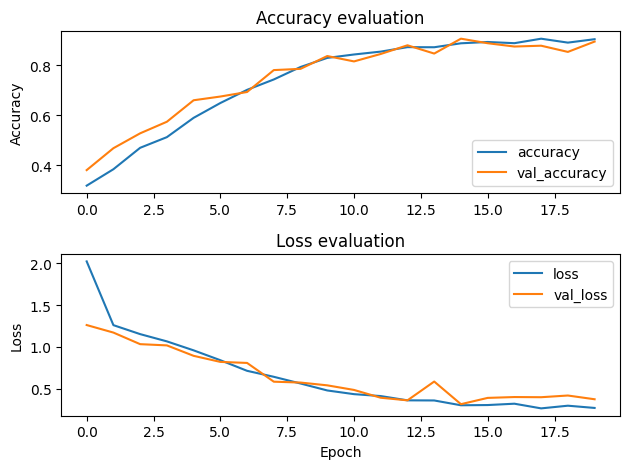

In [106]:
def plot_history(history):

    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="accuracy")
    axs[0].plot(history.history['val_accuracy'], label="val_accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy evaluation")

    # create loss subplot
    axs[1].plot(history.history["loss"], label="loss")
    axs[1].plot(history.history['val_loss'], label="val_loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss evaluation")

    fig.tight_layout()
    plt.show()
    
plot_history(history)

In [107]:
def predict(model, X, y):

    X = X[np.newaxis, ...]
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)

    print("Data Asli: {}, Hasil Prediksi: {}".format(y, predicted_index))

In [108]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def confusionMatrix(model, X_test, y_test):

  pred = model.predict(X_test)
  y_pred = []
  for i in pred:
      y_pred.append(np.argmax(i))

  # Ensure y_test_one_hot is used instead of y_test
  conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

  # Specify the correct display labels for all classes in your dataset
  display_labels = ['go', 'stop', 'right', 'left']

  # Visualize the confusion matrix
  cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=display_labels)
  cm_display.plot()
  cm_display.ax_.set_title("Confusion Matrix")
  plt.show()

  # Convert y_test_one_hot to class labels
  y_test_labels = np.argmax(y_test, axis=1)
  
  # Calculate accuracy using class labels
  accuracy = accuracy_score(y_test_labels, y_pred)
  
  # Calculate recall using class labels
  recall = recall_score(y_test_labels, y_pred, average='weighted')
  # Calculate precision using class labels
  precision = precision_score(y_test_labels, y_pred, average='weighted')
  F1 = f1_score(y_test_labels, y_pred, average='weighted')

  print("Accuracy :", accuracy*100, " %")
  print("Recall :", recall*100, " %")
  print("Precision :", precision*100, " %")
  print("F1-Score :", F1*100, " %")

45/45 [==============================] - 0s 5ms/step - loss: 0.4507 - accuracy: 0.9022

Test loss: 0.45067140460014343, 
Test accuracy: 90.21815657615662
1/1 [==============================] - 0s 93ms/step
Data Asli: [0. 1. 0. 0.], Hasil Prediksi: [1]
1/1 [==============================] - 0s 26ms/step
Data Asli: [0. 0. 1. 0.], Hasil Prediksi: [2]
1/1 [==============================] - 0s 28ms/step
Data Asli: [0. 0. 0. 1.], Hasil Prediksi: [3]
1/1 [==============================] - 0s 25ms/step
Data Asli: [0. 1. 0. 0.], Hasil Prediksi: [1]
1/1 [==============================] - 0s 25ms/step
Data Asli: [0. 1. 0. 0.], Hasil Prediksi: [1]
1/1 [==============================] - 0s 26ms/step
Data Asli: [0. 0. 0. 1.], Hasil Prediksi: [3]
1/1 [==============================] - 0s 25ms/step
Data Asli: [0. 0. 1. 0.], Hasil Prediksi: [2]
1/1 [==============================] - 0s 24ms/step
Data Asli: [0. 0. 0. 1.], Hasil Prediksi: [3]
1/1 [==============================] - 0s 24ms/step
Data Asli:

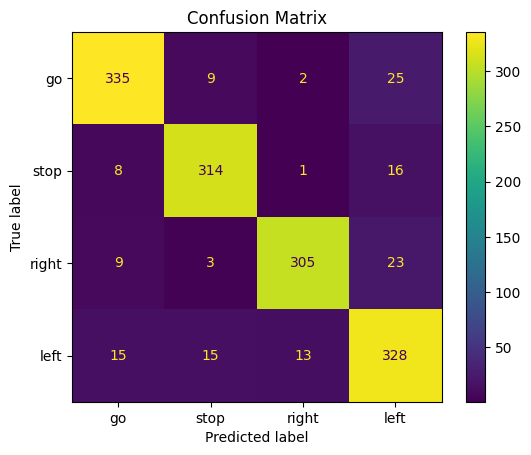

Accuracy : 90.21815622800844  %
Recall : 90.21815622800844  %
Precision : 90.37938880080422  %
F1-Score : 90.26260981539816  %
Waktu Mulai Komputasi: 1700783603.2932594
Waktu Akhir Komputasi: 1700783669.381742
Total Waktu Komputasi: 66.08848261833191


In [109]:
# evaluate network on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("\nTest loss: {}, \nTest accuracy: {}".format(test_loss, 100*test_acc))

# save model
model.save(SAVED_MODEL_PATH)

# Uji Prediksi
for _ in range(20):
    r = random.randint(0,len(X_test)-1)
    X_to_predict = X_test[r]
    y_to_predict = y_test[r]

    predict(model, X_to_predict, y_to_predict)
#Visualisasikan hasil Prediksi dan Akurasi
confusionMatrix(model, X_test, y_test)

print("Waktu Mulai Komputasi:", start_time)
print("Waktu Akhir Komputasi:", end_time)
print("Total Waktu Komputasi:", end_time - start_time)